In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
#Dataset used: https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000
path='/content/drive/My Drive/Colab Notebooks/Skin Cancer/hmnist_28_28_RGB.csv'


In [ ]:
df=pd.read_csv(path)

In [ ]:
df.tail()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,pixel0010,pixel0011,pixel0012,pixel0013,pixel0014,pixel0015,pixel0016,pixel0017,pixel0018,pixel0019,pixel0020,pixel0021,pixel0022,pixel0023,pixel0024,pixel0025,pixel0026,pixel0027,pixel0028,pixel0029,pixel0030,pixel0031,pixel0032,pixel0033,pixel0034,pixel0035,pixel0036,pixel0037,pixel0038,pixel0039,...,pixel2313,pixel2314,pixel2315,pixel2316,pixel2317,pixel2318,pixel2319,pixel2320,pixel2321,pixel2322,pixel2323,pixel2324,pixel2325,pixel2326,pixel2327,pixel2328,pixel2329,pixel2330,pixel2331,pixel2332,pixel2333,pixel2334,pixel2335,pixel2336,pixel2337,pixel2338,pixel2339,pixel2340,pixel2341,pixel2342,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
10010,183,165,181,182,165,180,184,166,182,188,168,182,181,157,162,205,179,188,221,199,214,224,202,215,226,201,205,223,198,206,230,207,219,228,201,211,229,203,210,223,...,225,197,195,222,193,193,228,199,202,231,202,204,227,203,206,230,211,219,231,217,223,222,204,207,202,179,180,205,180,181,208,185,187,208,186,186,206,187,189,0
10011,2,3,1,38,33,32,121,104,103,132,111,107,130,108,104,136,112,111,148,125,125,155,132,134,157,132,132,164,138,137,187,161,161,198,172,173,202,175,175,209,...,207,179,179,195,164,162,197,168,169,203,176,180,192,165,165,188,162,162,184,162,164,185,162,163,161,137,135,155,132,129,96,79,76,24,23,21,3,4,1,0
10012,132,118,118,167,149,149,175,156,160,184,164,167,195,173,175,210,191,199,212,195,201,210,189,193,218,194,203,217,191,195,217,195,199,224,201,203,236,211,215,250,...,200,169,165,217,183,179,241,211,210,242,216,215,239,214,213,234,208,208,224,198,196,206,180,177,226,202,201,214,192,190,204,181,178,181,159,153,172,151,145,0
10013,160,124,146,164,131,152,167,127,146,169,124,142,173,134,149,177,139,156,181,141,159,183,137,154,185,139,160,185,145,165,186,148,162,189,157,170,190,155,169,191,...,189,141,159,192,167,179,193,173,183,192,171,181,190,164,171,190,162,171,190,168,179,194,177,187,192,170,180,186,163,165,185,162,167,184,157,166,185,162,172,0
10014,175,142,121,181,150,134,181,150,133,178,145,127,177,144,122,177,146,123,179,148,126,185,157,140,177,142,113,174,138,112,177,141,117,175,139,108,178,145,117,181,...,183,150,136,178,141,116,184,151,135,188,160,147,183,153,131,180,146,131,173,137,115,157,88,68,146,32,47,145,24,48,159,79,82,174,137,125,175,139,126,6


In [ ]:
#reference https://github.com/rohanmandrekar/Cifar-10-/blob/master/best_attempt%28model7%29.ipynb

fractions=np.array([0.8,0.2])
df=df.sample(frac=1)
train_set, test_set = np.array_split(
    df, (fractions[:-1].cumsum() * len(df)).astype(int))

In [ ]:
print(len(train_set))

8012


In [ ]:
print(len(test_set))

2003


In [ ]:
df.label.unique()

array([4, 2, 6, 0, 1, 5, 3])

In [ ]:
# reference: https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000/discussion/183083
classes={0:('akiec', 'actinic keratoses and intraepithelial carcinomae'),
         1:('bcc' , 'basal cell carcinoma'),
         2:('bkl', 'benign keratosis-like lesions'),
         3:('df', 'dermatofibroma'),
         4:('nv', ' melanocytic nevi'),
         5:('vasc', ' pyogenic granulomas and hemorrhage'),
         6:('mel', 'melanoma'),}

In [ ]:
y_train=train_set['label']
x_train=train_set.drop(columns=['label'])
y_test=test_set['label']
x_test=test_set.drop(columns=['label'])

columns=list(x_train)

In [ ]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


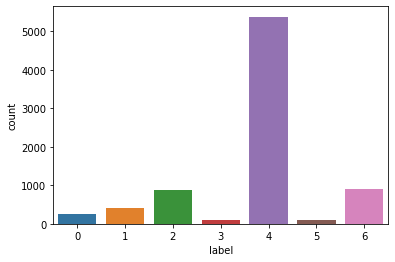

In [ ]:
import seaborn as sns

sns.countplot(train_set['label'])

In [ ]:
from imblearn.over_sampling import RandomOverSampler 
oversample = RandomOverSampler()
x_train,y_train  = oversample.fit_resample(x_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


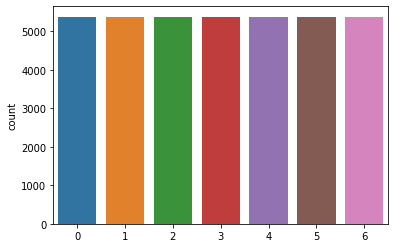

In [ ]:
sns.countplot(y_train)

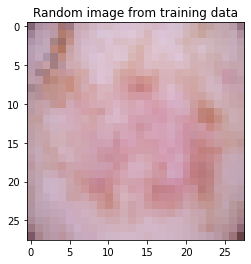

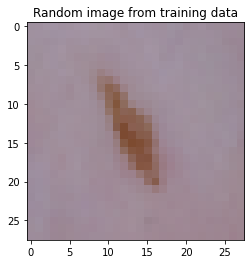

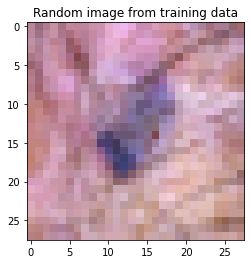

In [ ]:
import matplotlib.pyplot as plt
import random
num=random.randint(0,8000)
x_train=np.array(x_train, dtype=np.uint8).reshape(-1,28,28,3)

plt.imshow(x_train[num].reshape(28,28,3))
plt.title("Random image from training data")
plt.show()
num=random.randint(0,8000)
plt.imshow(x_train[num].reshape(28,28,3))
plt.title("Random image from training data")
plt.show()

num=random.randint(0,8000)
plt.imshow(x_train[num].reshape(28,28,3))
plt.title("Random image from training data")
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D
import tensorflow as tf

In [ ]:
model = Sequential()
model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu'))
model.add(Conv2D(256, kernel_size = (3,3), activation = 'relu'))
model.add(Flatten())
model.add(tf.keras.layers.Dropout(0.2))
model.add(Dense(256,activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))
model.add(Dense(128,activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(64,activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))
model.add(Dense(32,activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(7,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 32)        4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 5, 64)          2

In [ ]:
#reference: https://www.kaggle.com/dhruv1234/ham10000-skin-disease-classification
callback = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/My Drive/Colab Notebooks/Skin Cancer/best_model.h5',
                                                  monitor='val_acc', mode='max',
                                                 verbose=1, save_best_only=True)

In [ ]:
optimizer=tf.keras.optimizers.Adam(lr=0.001)
model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer =optimizer,
              metrics = ['accuracy'])
history = model.fit(x_train,
                    y_train,
                    validation_split=0.2,
                    batch_size = 128,
                    epochs = 50,
                    shuffle=True,
                    callbacks=[callback])

Epoch 1/50
236/236 [==============================] - 37s 12ms/step - loss: 1.6733 - accuracy: 0.3944 - val_loss: 3.9914 - val_accuracy: 0.0181
Epoch 2/50
236/236 [==============================] - 2s 9ms/step - loss: 0.5328 - accuracy: 0.8270 - val_loss: 2.6733 - val_accuracy: 0.1615
Epoch 3/50
236/236 [==============================] - 2s 8ms/step - loss: 0.2785 - accuracy: 0.9074 - val_loss: 1.0975 - val_accuracy: 0.4679
Epoch 4/50
236/236 [==============================] - 2s 9ms/step - loss: 0.2110 - accuracy: 0.9290 - val_loss: 1.1814 - val_accuracy: 0.5406
Epoch 5/50
236/236 [==============================] - 2s 9ms/step - loss: 0.1575 - accuracy: 0.9474 - val_loss: 1.2746 - val_accuracy: 0.5673
Epoch 6/50
236/236 [==============================] - 2s 9ms/step - loss: 0.1489 - accuracy: 0.9498 - val_loss: 0.6498 - val_accuracy: 0.6792
Epoch 7/50
236/236 [==============================] - 2s 9ms/step - loss: 0.1218 - accuracy: 0.9587 - val_loss: 0.9433 - val_accuracy: 0.6222
Epoc

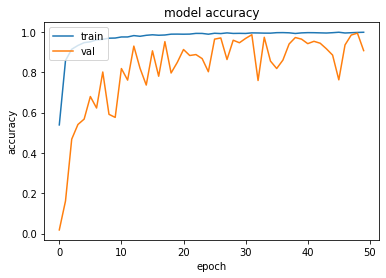

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


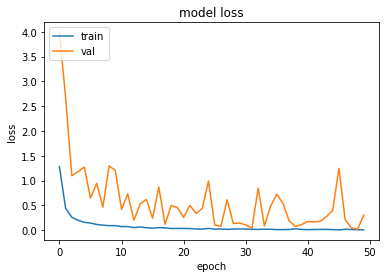

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.load_weights('/content/drive/My Drive/Colab Notebooks/Skin Cancer/best_model.h5')

In [ ]:
x_test=np.array(x_test).reshape(-1,28,28,3)
loss, acc = model.evaluate(x_test, y_test, verbose=2)

63/63 - 1s - loss: 0.2194 - accuracy: 0.9521


In [ ]:
import PIL
image=PIL.Image.open('/content/drive/My Drive/Colab Notebooks/Skin Cancer/tester.jpg')
image=image.resize((28,28))
img=np.array(image).reshape(-1,28,28,3)
result=model.predict(img)
result=result.tolist()
class_ind=result.index(max(result))
print(classes[class_ind])

('akiec', 'actinic keratoses and intraepithelial carcinomae')
